In [1]:
!pip install torchinfo
!nvidia-smi

Thu Jul  4 11:00:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [39]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from pytz import timezone

In [54]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 30
IMG_SIZE = 227
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5
LRN_K = 2.0
LRN_ALPHA = 0.00001
LRN_BETA = 0.75
LRN_N = 5

In [55]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [56]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [57]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [58]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [59]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [60]:
# AlexNet 현대적으로 재해석한 책에서 제시된 버전으로 구현 (multi-GPU 구현하지 않음, 배치정규화 차용)
class ModernAlexNet(nn.Module):
    def __init__(self):
        super(ModernAlexNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout(DROPOUT)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.fc6 = nn.Linear(6 * 6 * 256, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, NUM_CLASSES)

    def forward(self, x):
        # Conv 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.batchnorm1(x)
        # Conv 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        # Conv 3
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        # Conv 4
        x = F.relu(self.conv4(x))
        x = self.batchnorm4(x)
        # Conv 5
        x = F.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.pool(x)
        # FC 6
        x = x.view(-1, 6 * 6 * 256)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        # FC 7
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        # FC 8
        logits = self.fc8(x)
        return logits

torchinfo.summary(
    ModernAlexNet(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ModernAlexNet (ModernAlexNet)            [1, 3, 227, 227]          [1, 10]                   --                        --
├─Conv2d (conv1): 1-1                    [1, 3, 227, 227]          [1, 96, 55, 55]           34,944                    [11, 11]
├─MaxPool2d (pool): 1-2                  [1, 96, 55, 55]           [1, 96, 27, 27]           --                        3
├─BatchNorm2d (batchnorm1): 1-3          [1, 96, 27, 27]           [1, 96, 27, 27]           192                       --
├─Conv2d (conv2): 1-4                    [1, 96, 27, 27]           [1, 256, 27, 27]          614,656                   [5, 5]
├─MaxPool2d (pool): 1-5                  [1, 256, 27, 27]          [1, 256, 13, 13]          --                        3
├─BatchNorm2d (batchnorm2): 1-6          [1, 256, 13, 13]          [1, 256, 13, 13]          512                       --
├─Conv

In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
!ls

gdrive	imagenette2-320  sample_data  test  train


In [49]:
!tar -xvf gdrive/MyDrive/imagenette2-320.tgz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
imagenette2-320/train/n03888257/n03888257_16077.JPEG
imagenette2-320/train/n03888257/n03888257_23339.JPEG
imagenette2-320/train/n03888257/n03888257_44204.JPEG
imagenette2-320/train/n03888257/n03888257_61633.JPEG
imagenette2-320/train/n03888257/n03888257_15067.JPEG
imagenette2-320/train/n03888257/n03888257_75365.JPEG
imagenette2-320/train/n03888257/n03888257_63966.JPEG
imagenette2-320/train/n03888257/n03888257_3927.JPEG
imagenette2-320/train/n03888257/n03888257_20684.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-320/train/n03888257/n03888257_14016.JPEG
imagenette2-320/train/n03888257/n03888257_37776.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-320/train/n03888257/n03888257_17513.JPEG
imagenette2-320/train/n03888257/n03888257_17143.JPEG
imagenette2-320/train/n03888257/n03888257_6738.JPEG
imagenette2-320/train/n03888257/n03888257_4355.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_000

In [66]:
# transforms 정의하기
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),  # 이미지 크기 조정 및 무작위 자르기
    transforms.RandomHorizontalFlip(),       # 50% 확률로 수평 뒤집기
    transforms.ToTensor(),                   # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 검증 데이터에 적용할 transforms
valid_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),             # 이미지 크기 조정
    transforms.CenterCrop(IMG_SIZE),         # 중앙에서 크롭
    transforms.ToTensor(),                   # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 생성
train_dataset = datasets.ImageFolder('imagenette2-320/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('imagenette2-320/val', transform=valid_transforms)

# # 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

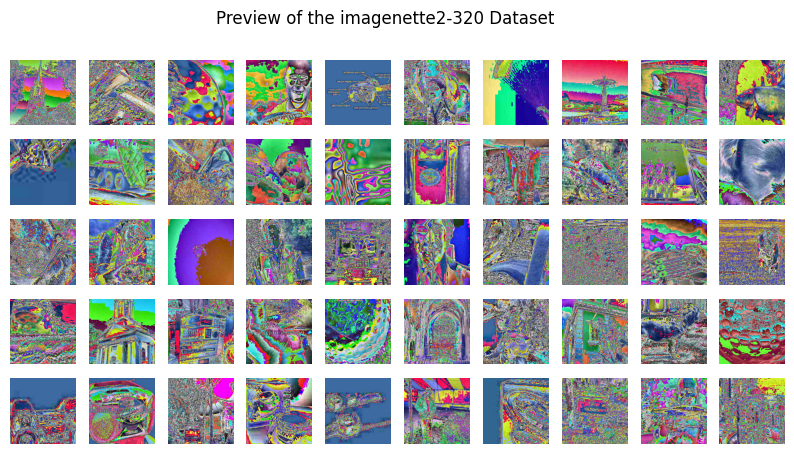

Train dataset size: 9469
Validation dataset size: 3925


In [67]:
# 불러온 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(10, 5))  # 창 크기 조정
for i, (image, label) in enumerate(train_loader):
    if i == ROW_IMG * N_ROWS:
        break
    ax = plt.subplot(N_ROWS, ROW_IMG, i + 1)
    ax.axis("off")
    # 이미지 표시하기
    plt.imshow(transforms.ToPILImage()(image[0]))

fig.suptitle("Preview of the imagenette2-320 Dataset")
plt.show()


# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

21:00:44 ---  Epoch: 0	Train loss: 3.3154	Valid loss: 1.9569	Train accuracy: 27.90	Valid accuracy: 30.37
21:02:46 ---  Epoch: 1	Train loss: 1.9973	Valid loss: 1.7697	Train accuracy: 33.78	Valid accuracy: 38.50
21:04:47 ---  Epoch: 2	Train loss: 1.9346	Valid loss: 1.7176	Train accuracy: 36.58	Valid accuracy: 42.11
21:06:46 ---  Epoch: 3	Train loss: 1.8290	Valid loss: 1.6927	Train accuracy: 38.87	Valid accuracy: 43.41
21:08:43 ---  Epoch: 4	Train loss: 1.7684	Valid loss: 1.5475	Train accuracy: 45.83	Valid accuracy: 50.57
21:10:41 ---  Epoch: 5	Train loss: 1.6930	Valid loss: 1.4676	Train accuracy: 47.50	Valid accuracy: 53.30
21:12:39 ---  Epoch: 6	Train loss: 1.6348	Valid loss: 1.4182	Train accuracy: 48.71	Valid accuracy: 55.49
21:14:37 ---  Epoch: 7	Train loss: 1.5663	Valid loss: 1.3270	Train accuracy: 50.71	Valid accuracy: 56.23
21:16:33 ---  Epoch: 8	Train loss: 1.5191	Valid loss: 1.2085	Train accuracy: 54.08	Valid accuracy: 60.97
21:18:30 ---  Epoch: 9	Train loss: 1.4944	Valid loss: 1

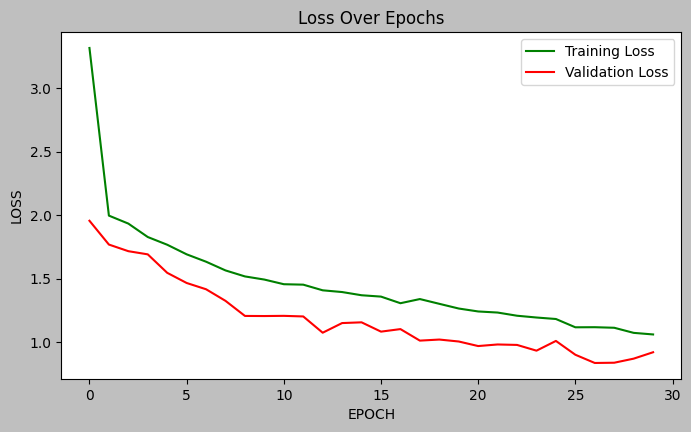

In [68]:
torch.manual_seed(RANDOM_SEED)

model = ModernAlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)